In [4]:
import numpy as np
import pandas as pd
import nbimporter
from Kuramoto_dynamicalModels import *
import ipdb
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.tsatools import detrend
import statsmodels
import matplotlib.pyplot as plt


from scipy.fftpack import fftfreq
from scipy.signal import csd, welch

Importing Jupyter notebook from Kuramoto_dynamicalModels.ipynb


In [19]:
def transfer_fun(f,coefs):
    '''
    Computes the transfer function, H, where S = H \Sigma H* and S is the 
    spectral density matrix
    
            H = I - A_1 e^{2*pi*i*f} - ... - A_p e^{2*pi*i*f}
    
    where A_1, ..., A_p are the VAR coefficient matrices
    
    Input:
        f: frequency to take the Fourier transform
        coefs: numpy array of VAR coefficient matrices
               VAR(  ).fit(  ).coefs
               
    return
        H: returns transfer function
    '''
    
    coefs_length = coefs.shape[0]
    seq_nums = np.array(range(1,coefs_length+1))
    exponential = np.exp(-2*np.pi*1j*seq_nums*f)
    ident_mat = np.eye(coefs[0,:,:].shape[0])
    transfer_mat = np.linalg.inv(ident_mat - np.einsum('ijk,i',coefs,exponential))
    return np.matrix(transfer_mat)

def estimate_spectral_density_matrix(f,Sigma,coefs):
    H_f = transfer_fun(f,coefs)
    est_S = H_f.dot(Sigma).dot(H_f.H)
    return est_S

def fit_VAR_model(df,time_lag = 0):

    model = VAR(df)
    
    if time_lag == 0:
        #find optimal lag order by Akaike information criteria
        lag_orders_data = model.select_order(trend='nc')
        time_lag = lag_orders_data.selected_orders['aic']
    elif isinstance(time_lag, str):
        #find optimal lag order by Akaike information criteria
        lag_orders_data = model.select_order(trend='nc')
        time_lag = lag_orders_data.selected_orders[time_lag]
        
    #fit to optimal BIC lag number
    results = model.fit(time_lag,trend='nc')
    return results
def spectral_granger_freq_one(var1,var2,df,results,fs=1.0,nperseg=1024, plot_true=False):
    #generate dft frequencies 
    
    frequencies_array = fftfreq(nperseg)
    fir_half_freq = frequencies_array[:int(nperseg/2)]
    sec_half_freq = frequencies_array[int(nperseg/2):]
    frequencies_array = np.concatenate((sec_half_freq,fir_half_freq), axis=0)
    
    ind_var1 = df.columns.get_loc(var1)
    ind_var2 = df.columns.get_loc(var2)
    
    Sigma = np.cov((results.resid.values).T)

    #define transfer function 
    def H(f):
        return transfer_fun(f,results.coefs)
    
    #define spectral density function 
    def estimate_spectral_density(f):
        return estimate_spectral_density_matrix(f,Sigma,results.coefs)
        
    #I'm not sure what to do here
    estimate_causality_var22var1 = np.zeros(frequencies_array.shape[0])
    estimate_causality_var12var2 = np.zeros(frequencies_array.shape[0])
  
    for i,f in enumerate(frequencies_array):
        H_mat = H(f)
        
        est_S = estimate_spectral_density(f)
        
        var22var1entry = -np.log(1- (Sigma[ind_var2,ind_var2] - \
            (Sigma[ind_var1,ind_var2]**2/Sigma[ind_var1,ind_var1]))*np.absolute(H_mat[ind_var1,ind_var2])**2/est_S[ind_var1,ind_var1].real)
        
        var12var2entry = -np.log(1- (Sigma[ind_var1,ind_var1] - \
            (Sigma[ind_var1,ind_var2]**2/Sigma[ind_var2,ind_var2]))*np.absolute(H_mat[ind_var2,ind_var1])**2/est_S[ind_var2,ind_var2].real) 
        
        estimate_causality_var22var1[i] = var22var1entry
        estimate_causality_var12var2[i] = var12var2entry
    
    scaled_freq= frequencies_array*fs
    
    if plot_true == True:
        plt.clf()
        plt.close()
        plt.plot(frequencies_array,estimate_causality_var22var1)
        plt.plot(frequencies_array,estimate_causality_var12var2,':')
        plt.title('Spectral Granger Causality between ' + var1 + ' and ' + var2)
        plt.legend([var1,var2])
        plt.xlabel('frequency (Hz)')
        plt.ylabel('Spectral Density (Volts squared per Hz)')
        plt.show()
        
    return [frequencies_array,estimate_causality_var22var1,estimate_causality_var12var2]

# Strong Coupling

In [20]:
# these are our constants
N = 5  # number of variables
K = 10 #coupling
omega =  np.array([ 2.31246433, 35.50794494, 53.41350736, 50.23353682,  5.63392492])  # natural frequency
theta0 = np.array([117.35002435, 261.94283291, 260.06912657, 293.69995793,235.11319532]) # initial state 
tinit = 0.0
tmax = 100.0
dt =  0.01

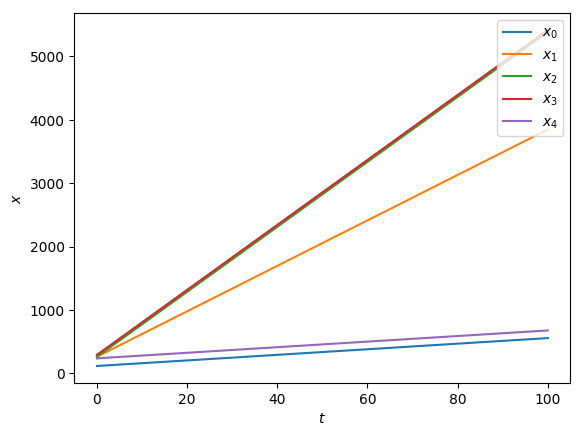

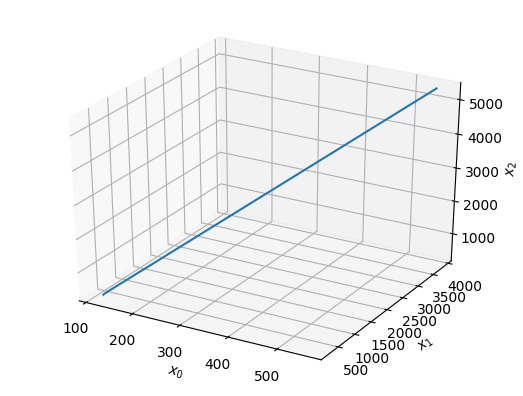

In [21]:
kuramoto = Kuramoto(N,K,omega)
sol = kuramoto.integrate(tinit, tmax, dt, theta0)
kuramoto.evolution_plot()
kuramoto.trajectory_plot()

In [22]:
kuramoto_df = pd.DataFrame(data= sol[1],    
                columns=['x0','x1','x2','x3','x4'])
kuramoto_transform_df = kuramoto_df.transform([np.cos,np.sin])
kuramoto_transform_df.columns = [''.join(col).strip() for col in kuramoto_transform_df.columns.values]

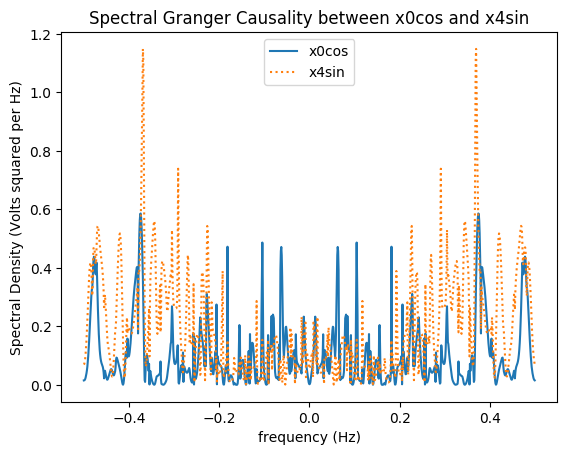

In [23]:
kuramoto_transform_df_wo_x0sin=kuramoto_transform_df.drop(columns=['x0sin'])
results = fit_VAR_model(kuramoto_transform_df_wo_x0sin,time_lag = 0)
[frequencies_array,estimate_causality_var22var1,estimate_causality_var12var2] = \
        spectral_granger_freq_one('x0cos','x4sin',kuramoto_transform_df_wo_x0sin,results,fs=1/dt,plot_true=True)

#plt.clf()
#plt.plot(frequencies_array,estimate_causality_var22var1)
#plt.plot(frequencies_array,estimate_causality_var12var2,':')
#plt.show()